In [18]:
import os
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing import image
from IPython.display import Image

# Dataset: https://www.kaggle.com/datasets/phylake1337/fire-dataset/code

In [4]:
df = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])])

for dirname, _, filenames in os.walk('fire_dataset/non_fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])])

df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,fire_dataset/non_fire_images\non_fire.80.png,non_fire
1,fire_dataset/fire_images\fire.88.png,fire
2,fire_dataset/fire_images\fire.464.png,fire
3,fire_dataset/fire_images\fire.665.png,fire
4,fire_dataset/non_fire_images\non_fire.141.png,non_fire
5,fire_dataset/fire_images\fire.735.png,fire
6,fire_dataset/fire_images\fire.658.png,fire
7,fire_dataset/fire_images\fire.84.png,fire
8,fire_dataset/fire_images\fire.378.png,fire
9,fire_dataset/fire_images\fire.666.png,fire


In [5]:
label = 'fire'
data = df[df['label'] == label]

pics = 2
for i in range(pics):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    Image(filename=path)

In [6]:
label = 'non_fire'
data = df[df['label'] == label]

pics = 2
for i in range(pics):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    Image(filename=path)

In [7]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [8]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [9]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


In [10]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,fire_dataset/non_fire_images\non_fire.80.png,non_fire,400,600
1,fire_dataset/fire_images\fire.88.png,fire,338,600
2,fire_dataset/fire_images\fire.464.png,fire,923,1600
3,fire_dataset/fire_images\fire.665.png,fire,366,750
4,fire_dataset/non_fire_images\non_fire.141.png,non_fire,920,2500


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 128)      

In [12]:
from keras.metrics import Recall,AUC
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])


Epoch 1/15


25/25 [==============================] - 33s 1s/step - loss: 0.3375 - accuracy: 0.8388 - recall: 0.6533 - auc: 0.8976 - val_loss: 0.1574 - val_accuracy: 0.9347 - val_recall: 0.9333 - val_auc: 0.9846 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 30s 1s/step - loss: 0.1260 - accuracy: 0.9513 - recall: 0.8744 - auc: 0.9866 - val_loss: 0.1372 - val_accuracy: 0.9397 - val_recall: 0.8000 - val_auc: 0.9864 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 31s 1s/step - loss: 0.1243 - accuracy: 0.9650 - recall: 0.9146 - auc: 0.9838 - val_loss: 0.3584 - val_accuracy: 0.8543 - val_recall: 0.9778 - val_auc: 0.9738 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 30s 1s/step - loss: 0.1499 - accuracy: 0.9400 - recall: 0.8543 - auc: 0.9781 - val_loss: 0.1340 - val_accuracy: 0.9447 - val_recall: 0.7778 - val_auc: 0.9852 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 31s 1s/step - loss: 0.1259 - accuracy: 0.9475 - recal

In [13]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 4s 499ms/step - loss: 0.1031 - accuracy: 0.9698 - recall: 0.9111 - auc: 0.9912
loss: 0.10
accuracy: 0.97
recall: 0.91
auc: 0.99


In [14]:
pred = model.predict(val_gen)

7/7 [==============================] - 4s 537ms/step


In [15]:
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

pred = pred.astype(int)
pred.flatten()

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0])

In [16]:
print("Incorrect Predictions")
print("Index | Predicted | Actual")

predList = []
i = 0
while i < len(pred):
    if pred[i][0] != val_gen.labels[i]:
        print(i, "\t", pred[i], "\t", val_gen.labels[i], "\t", val_gen.filenames[i])
        predList.append(val_gen.filenames[i])
    i += 1

Incorrect Predictions
Index | Predicted | Actual
0 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.80.png
2 	 [1] 	 0 	 fire_dataset/fire_images\fire.464.png
7 	 [1] 	 0 	 fire_dataset/fire_images\fire.84.png
11 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.110.png
12 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.39.png
14 	 [1] 	 0 	 fire_dataset/fire_images\fire.752.png
20 	 [1] 	 0 	 fire_dataset/fire_images\fire.249.png
22 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.128.png
25 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.84.png
26 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.228.png
33 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.244.png
34 	 [1] 	 0 	 fire_dataset/fire_images\fire.214.png
38 	 [1] 	 0 	 fire_dataset/fire_images\fire.478.png
39 	 [0] 	 1 	 fire_dataset/non_fire_images\non_fire.90.png
40 	 [1] 	 0 	 fire_dataset/fire_images\fire.109.png
41 	 [1] 	 0 	 fire_dataset/fire_images\fire.262.png
44 	 [0] 	 1 	 fire_dataset/non_fire_images\non

fire_dataset/non_fire_images\non_fire.106.png


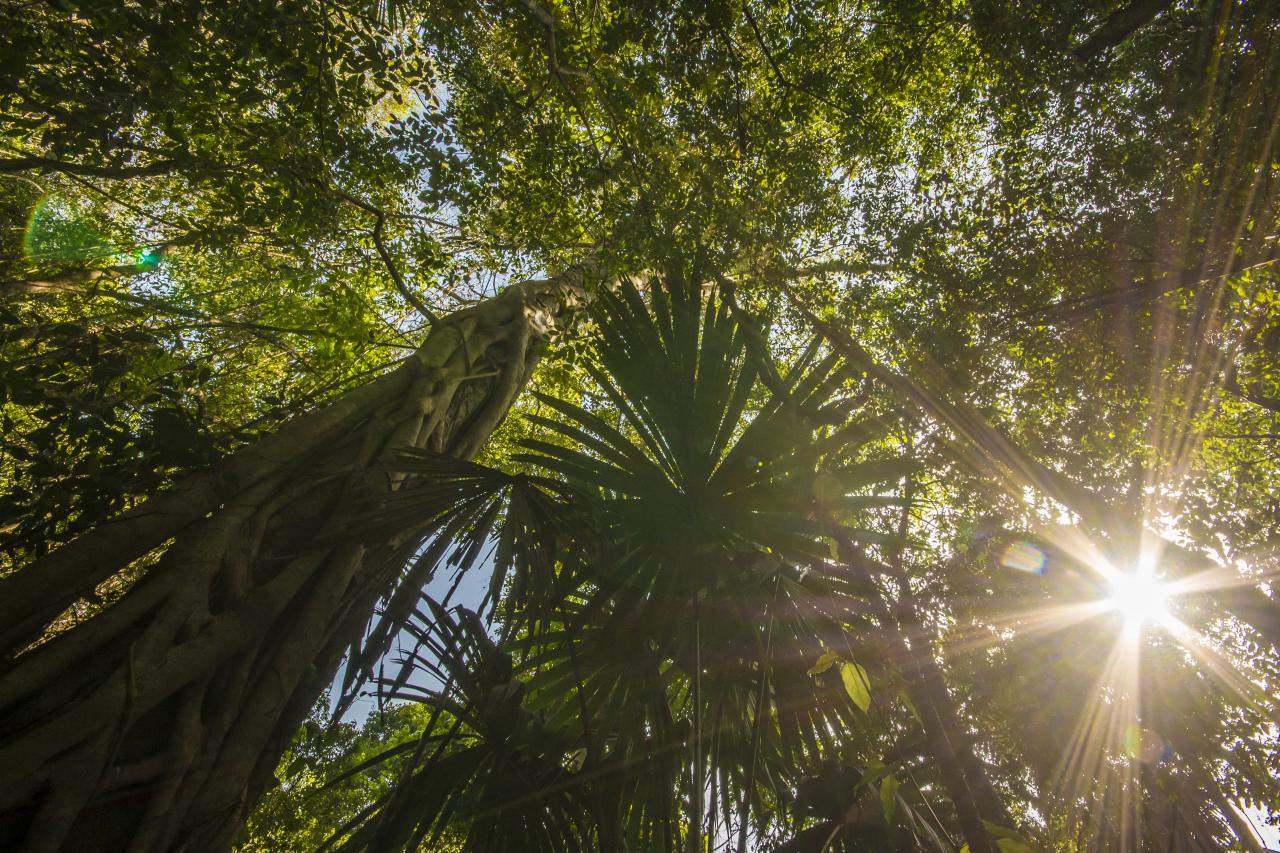

In [17]:
import random

randInt = random.randint(0, len(predList)-1)
print(predList[randInt])
Image(filename=predList[randInt])